# Absolute Momentum

Description

In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from utils import historic_cdi, historic_imab5, STAR_DATE, END_DATE

### Importando os dados

In [58]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [59]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)
ibov = (ibov_prices / ibov_prices.iloc[0])

In [60]:
absolute_prices = pd.concat([ibov, cdi, imab5], keys=['IBOV', 'CDI', 'IMA-B 5'], join='outer', axis=1)
absolute_prices = absolute_prices.dropna()

absolute_prices

,IBOV,CDI,IMA-B 5
2004-01-02,1.000000,1.000000,1.000000
2004-01-05,1.048429,1.000601,1.000576
2004-01-06,1.050390,1.001202,1.001922
2004-01-07,1.038984,1.001803,1.003517
2004-01-08,1.056672,1.002405,1.007081
...,...,...,...
2024-09-02,6.013856,8.215417,11.256346
2024-09-03,5.985877,8.218644,11.254458
2024-09-04,6.064201,8.221871,11.275119
2024-09-05,6.081622,8.225100,11.288138


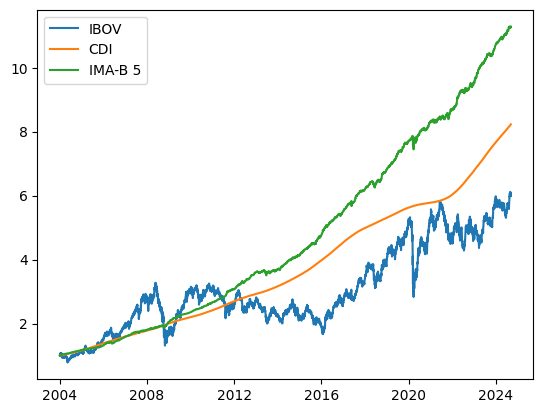

In [61]:

plt.plot(absolute_prices)
plt.legend(absolute_prices.columns)
plt.show()

In [62]:
ytd_returns = absolute_prices.pct_change(periods=252).dropna()

ytd_returns

,IBOV,CDI,IMA-B 5
2005-01-06,0.085632,0.164780,0.177314
2005-01-07,0.051632,0.164836,0.176687
2005-01-10,0.030370,0.164891,0.175603
2005-01-11,0.045026,0.164947,0.174425
2005-01-12,0.033436,0.165002,0.170868
...,...,...,...
2024-09-02,0.140004,0.113517,0.078560
2024-09-03,0.143089,0.113408,0.079185
2024-09-04,0.175986,0.113300,0.083757
2024-09-05,0.157847,0.113191,0.084500


In [63]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,IBOV,CDI,IMA-B 5
2005-01-06,0.085632,0.164780,0.177314
2005-02-01,-0.003178,0.166668,0.161056
2005-03-01,0.299620,0.168233,0.140095
2005-04-01,0.274952,0.170637,0.137230
2005-05-02,0.158554,0.173259,0.140051
...,...,...,...
2024-05-02,0.235118,0.124183,0.084812
2024-06-03,0.106034,0.121508,0.090099
2024-07-01,0.061222,0.118929,0.082131
2024-08-01,0.059973,0.115970,0.085338


In [64]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['CDI']),
]

cases = ['IBOV', 'IMA-B 5']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,IBOV,CDI,IMA-B 5,Investment
2005-01-06,0.085632,0.164780,0.177314,IMA-B 5
2005-01-07,0.051632,0.164836,0.176687,IMA-B 5
2005-01-10,0.030370,0.164891,0.175603,IMA-B 5
2005-01-11,0.045026,0.164947,0.174425,IMA-B 5
2005-01-12,0.033436,0.165002,0.170868,IMA-B 5
...,...,...,...,...
2024-09-02,0.140004,0.113517,0.078560,IBOV
2024-09-03,0.143089,0.113408,0.079185,IBOV
2024-09-04,0.175986,0.113300,0.083757,IBOV
2024-09-05,0.157847,0.113191,0.084500,IBOV


In [65]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5    0.51
IBOV       0.49
Name: proportion, dtype: float64

In [66]:
absolute_momentum = absolute_prices.pct_change().join(ytd_returns[['Investment']], how='right')

absolute_momentum

,IBOV,CDI,IMA-B 5,Investment
2005-01-06,-0.013162,0.000648,0.000196,IMA-B 5
2005-01-07,0.015595,0.000648,0.000042,IMA-B 5
2005-01-10,-0.018386,0.000648,0.000424,IMA-B 5
2005-01-11,0.003211,0.000648,0.000588,IMA-B 5
2005-01-12,0.005745,0.000648,0.000511,IMA-B 5
...,...,...,...,...
2024-09-02,-0.007522,0.000393,0.000510,IBOV
2024-09-03,-0.004653,0.000393,-0.000168,IBOV
2024-09-04,0.013085,0.000393,0.001836,IBOV
2024-09-05,0.002873,0.000393,0.001155,IBOV


In [67]:
absolute_momentum['Absolute Momentum'] = absolute_momentum.apply(lambda row: row[row['Investment']], axis=1)
absolute_momentum = absolute_momentum.drop(columns=['Investment'])

absolute_momentum

,IBOV,CDI,IMA-B 5,Absolute Momentum
2005-01-06,-0.013162,0.000648,0.000196,0.000196
2005-01-07,0.015595,0.000648,0.000042,0.000042
2005-01-10,-0.018386,0.000648,0.000424,0.000424
2005-01-11,0.003211,0.000648,0.000588,0.000588
2005-01-12,0.005745,0.000648,0.000511,0.000511
...,...,...,...,...
2024-09-02,-0.007522,0.000393,0.000510,-0.007522
2024-09-03,-0.004653,0.000393,-0.000168,-0.004653
2024-09-04,0.013085,0.000393,0.001836,0.013085
2024-09-05,0.002873,0.000393,0.001155,0.002873


In [68]:
absolute_momentum_eval = (1 + absolute_momentum).cumprod()
absolute_momentum_eval = (absolute_momentum_eval / absolute_momentum_eval.iloc[0]) - 1

absolute_momentum_eval

,IBOV,CDI,IMA-B 5,Absolute Momentum
2005-01-06,0.000000,0.000000,0.000000,0.000000
2005-01-07,0.015595,0.000648,0.000042,0.000042
2005-01-10,-0.003078,0.001297,0.000466,0.000466
2005-01-11,0.000123,0.001946,0.001055,0.001055
2005-01-12,0.005869,0.002596,0.001567,0.001567
...,...,...,...,...
2024-09-02,4.539500,6.053190,8.561036,5.485738
2024-09-03,4.513728,6.055960,8.559433,5.455563
2024-09-04,4.585874,6.058731,8.576982,5.540033
2024-09-05,4.601921,6.061503,8.588040,5.558820


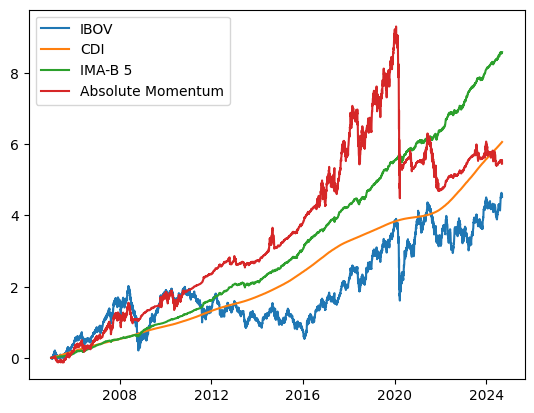

In [69]:
plt.plot(absolute_momentum_eval)
plt.legend(absolute_momentum_eval.columns)
plt.show()